# Phase 2: The Vibration Gauntlet (NASA Bearing Dataset)

This notebook processes raw vibration signal data from the NASA bearing dataset to build unsupervised anomaly detection models.

## Objectives:
1. Load and process NASA bearing vibration time-series data
2. Extract statistical and frequency-domain features from raw signals
3. Train unsupervised anomaly detection models (IsolationForest, OneClassSVM)
4. Register models in MLflow for production deployment

## Dataset: NASA Bearing Dataset
- **Source**: IMS Bearing Dataset from NASA Prognostics Center
- **Type**: Vibration time-series data from accelerometers
- **Structure**: 8-channel accelerometer readings (4 bearings × 2 sensors each)
- **Sampling**: 20kHz sampling frequency, 1-second windows

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import mlflow
import os
import glob
from scipy.stats import kurtosis, skew
from scipy.fft import fft, fftfreq
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# MLflow configuration
tracking_uri = "http://mlflow:5000" if os.getenv("DOCKER_ENV") == "true" else "http://localhost:5000"
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment("Vibration Gauntlet (NASA)")

print(f"MLflow tracking URI set to: {mlflow.get_tracking_uri()}")
print(f"Current working directory: {os.getcwd()}")

# Ensure output directory exists
os.makedirs('docs/ml', exist_ok=True)

2025/08/18 15:55:39 INFO mlflow.tracking.fluent: Experiment with name 'Vibration Gauntlet (NASA)' does not exist. Creating a new experiment.


MLflow tracking URI set to: http://mlflow:5000
Current working directory: /app


In [2]:
def load_bearing_data(file_path):
    """
    Load NASA bearing data file containing 8-channel vibration readings.
    
    Returns:
        np.array: Vibration data with shape (n_samples, 8_channels)
    """
    try:
        # Load the data file - each row contains 8 accelerometer readings
        data = np.loadtxt(file_path)
        return data
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def extract_vibration_features(signal_window, sampling_freq=20000):
    """
    Extract comprehensive features from a vibration signal window.
    
    Parameters:
        signal_window (np.array): 1D vibration signal
        sampling_freq (int): Sampling frequency in Hz
    
    Returns:
        dict: Dictionary containing extracted features
    """
    features = {}
    
    # Statistical Features
    features['rms'] = np.sqrt(np.mean(signal_window**2))  # Root Mean Square - overall energy
    features['peak_to_peak'] = np.max(signal_window) - np.min(signal_window)  # Peak-to-peak amplitude
    features['kurtosis'] = kurtosis(signal_window)  # Kurtosis - indicates impulsiveness (bearing defects)
    features['skewness'] = skew(signal_window)  # Skewness - indicates asymmetry
    features['std'] = np.std(signal_window)  # Standard deviation
    features['mean'] = np.mean(signal_window)  # Mean value
    features['crest_factor'] = np.max(np.abs(signal_window)) / features['rms']  # Crest factor
    
    # Frequency Domain Features (FFT)
    fft_values = np.abs(fft(signal_window))
    freqs = fftfreq(len(signal_window), 1/sampling_freq)
    
    # Only consider positive frequencies
    positive_freq_idx = freqs > 0
    fft_positive = fft_values[positive_freq_idx]
    freqs_positive = freqs[positive_freq_idx]
    
    # Find dominant frequency
    dominant_freq_idx = np.argmax(fft_positive)
    features['dominant_freq'] = freqs_positive[dominant_freq_idx]
    features['dominant_freq_amplitude'] = fft_positive[dominant_freq_idx]
    
    # Spectral centroid (center of mass of spectrum)
    features['spectral_centroid'] = np.sum(freqs_positive * fft_positive) / np.sum(fft_positive)
    
    # High frequency content (above 1kHz)
    high_freq_mask = freqs_positive > 1000
    features['high_freq_energy'] = np.sum(fft_positive[high_freq_mask]**2) / np.sum(fft_positive**2)
    
    return features

def process_bearing_file(file_path, window_size=2048):
    """
    Process a single bearing data file and extract features from multiple windows.
    
    Parameters:
        file_path (str): Path to bearing data file
        window_size (int): Size of sliding window for feature extraction
    
    Returns:
        list: List of feature dictionaries
    """
    data = load_bearing_data(file_path)
    if data is None:
        return []
    
    # Extract filename for timestamp parsing
    filename = os.path.basename(file_path)
    
    features_list = []
    
    # Process each sensor channel (8 channels total)
    for channel in range(data.shape[1]):
        channel_data = data[:, channel]
        
        # Extract features from overlapping windows
        step_size = window_size // 2  # 50% overlap
        for start_idx in range(0, len(channel_data) - window_size, step_size):
            window = channel_data[start_idx:start_idx + window_size]
            
            # Extract features
            features = extract_vibration_features(window)
            
            # Add metadata
            features['filename'] = filename
            features['channel'] = channel
            features['window_start'] = start_idx
            features['bearing_id'] = f"bearing_{(channel // 2) + 1}"  # 2 sensors per bearing
            features['sensor_position'] = 'horizontal' if channel % 2 == 0 else 'vertical'
            
            features_list.append(features)
    
    return features_list

# Test the functions with a sample file
print("Testing signal processing functions...")

# Get the first available data file
data_dir = "data/nasa_bearing_dataset/4. Bearings/1st_test"
sample_files = glob.glob(os.path.join(data_dir, "*"))[:3]  # Test with first 3 files

if sample_files:
    print(f"Processing sample files: {len(sample_files)} files")
    
    # Process first file to verify functionality
    sample_features = process_bearing_file(sample_files[0], window_size=1024)  # Smaller window for testing
    
    print(f"Extracted {len(sample_features)} feature vectors from first file")
    if sample_features:
        print("Sample features:")
        for key, value in list(sample_features[0].items())[:8]:
            print(f"  {key}: {value:.4f}" if isinstance(value, (int, float)) else f"  {key}: {value}")
else:
    print("No data files found. Please check the data directory path.")

Testing signal processing functions...
Processing sample files: 3 files
Extracted 304 feature vectors from first file
Sample features:
  rms: 0.1513
  peak_to_peak: 0.7740
  kurtosis: 0.5634
  skewness: -0.1409
  std: 0.0912
  mean: -0.1207
  crest_factor: 3.8266
  dominant_freq: 996.0938


=== Phase 2: Vibration Signal Processing ===
Found 2156 bearing data files
Processing 20 files for feature extraction...
Processing file 1/20: 2003.10.22.12.06.24


Processing file 6/20: 2003.10.22.12.29.13


Processing file 11/20: 2003.10.22.12.54.13


Processing file 16/20: 2003.10.22.13.19.13


Creating feature dataset with 2880 feature vectors...

Feature dataset shape: (2880, 16)
Number of unique files: 20
Number of bearings: 4
Sensor positions: ['horizontal' 'vertical']

Key vibration features summary:
               rms  peak_to_peak     kurtosis     skewness  crest_factor  \
count  2880.000000   2880.000000  2880.000000  2880.000000   2880.000000   
mean      0.122405      0.666706     0.690521    -0.003815      3.500876   
std       0.011199      0.134383     0.721376     0.107218      0.559107   
min       0.056400      0.374000    -0.366259    -0.396415      2.332677   
25%       0.116706      0.571000     0.214352    -0.069049      3.100681   
50%       0.123855      0.655000     0.527384    -0.009503      3.395641   
75%       0.130351      0.750000     0.981254     0.056316      3.776695   
max       0.142551      1.265000     7.421124     0.630088      6.289807   

       dominant_freq  spectral_centroid  high_freq_energy  
count    2880.000000        2880.000000 

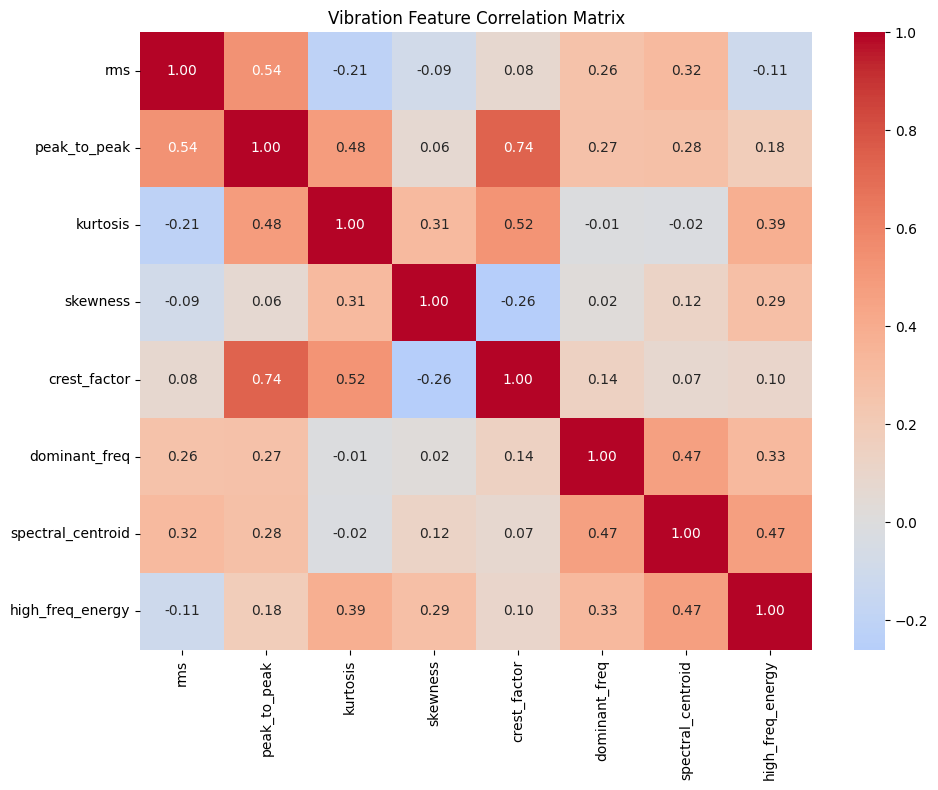


Sample of processed vibration features:
  bearing_id sensor_position       rms  kurtosis  dominant_freq
0  bearing_1      horizontal  0.126934  0.279045     986.328125
1  bearing_1      horizontal  0.123933  0.457330     986.328125
2  bearing_1      horizontal  0.123662  0.310669     986.328125
3  bearing_1      horizontal  0.124955  0.793580     986.328125
4  bearing_1      horizontal  0.121569  0.821942     986.328125
5  bearing_1      horizontal  0.126302  2.092264     986.328125
6  bearing_1      horizontal  0.126785  1.993748     986.328125
7  bearing_1      horizontal  0.123201  0.411748     986.328125
8  bearing_1      horizontal  0.129915  0.709438     986.328125
9  bearing_1      horizontal  0.128147  0.810863     986.328125


In [3]:
# Load and process all bearing data files
print("=== Phase 2: Vibration Signal Processing ===")

# Define data paths
nasa_data_dir = "data/nasa_bearing_dataset/4. Bearings/1st_test"
all_files = sorted(glob.glob(os.path.join(nasa_data_dir, "*")))

print(f"Found {len(all_files)} bearing data files")

# Process a subset of files for this demonstration (first 20 files)
# In production, you would process all files
sample_files = all_files[:20]
print(f"Processing {len(sample_files)} files for feature extraction...")

# Extract features from all files
all_features = []
window_size = 2048  # 2048 samples ≈ 0.1 seconds at 20kHz

for i, file_path in enumerate(sample_files):
    if i % 5 == 0:  # Progress indicator
        print(f"Processing file {i+1}/{len(sample_files)}: {os.path.basename(file_path)}")
    
    file_features = process_bearing_file(file_path, window_size=window_size)
    all_features.extend(file_features)

# Convert to DataFrame
print(f"Creating feature dataset with {len(all_features)} feature vectors...")
features_df = pd.DataFrame(all_features)

# Display dataset info
print(f"\nFeature dataset shape: {features_df.shape}")
print(f"Number of unique files: {features_df['filename'].nunique()}")
print(f"Number of bearings: {features_df['bearing_id'].nunique()}")
print(f"Sensor positions: {features_df['sensor_position'].unique()}")

# Statistical summary of key features
feature_cols = ['rms', 'peak_to_peak', 'kurtosis', 'skewness', 'crest_factor', 
                'dominant_freq', 'spectral_centroid', 'high_freq_energy']

print(f"\nKey vibration features summary:")
print(features_df[feature_cols].describe())

# Create feature correlation matrix
correlation_matrix = features_df[feature_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Vibration Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('docs/ml/vibration_feature_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

# Display sample of the processed data
print(f"\nSample of processed vibration features:")
print(features_df[['bearing_id', 'sensor_position', 'rms', 'kurtosis', 'dominant_freq']].head(10))

=== Anomaly Detection Model Training ===
Training data shape: (2880, 10)
Features used: ['rms', 'peak_to_peak', 'kurtosis', 'skewness', 'std', 'crest_factor', 'dominant_freq', 'dominant_freq_amplitude', 'spectral_centroid', 'high_freq_energy']

Training IsolationForest...


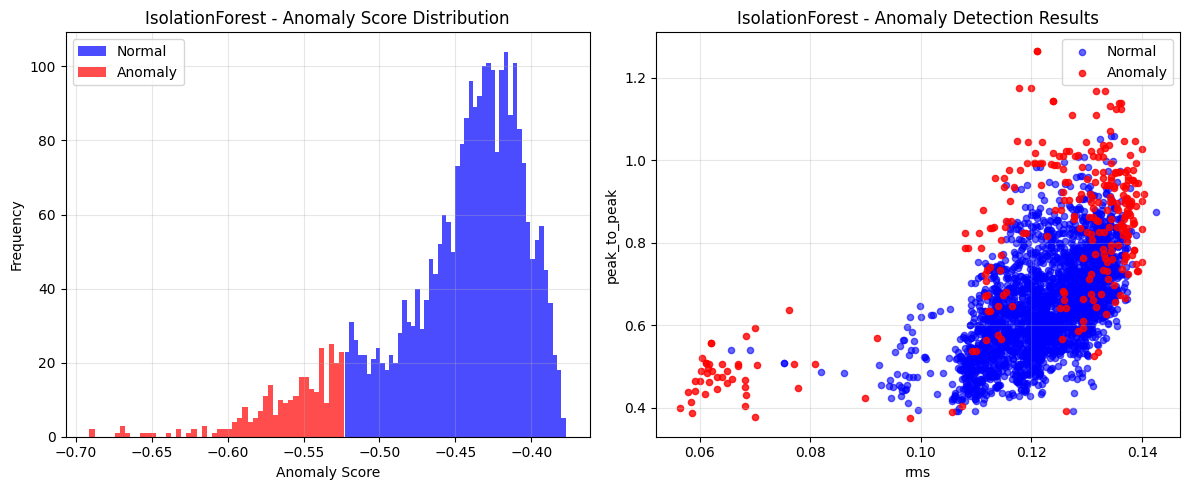

2025/08/18 15:55:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Successfully registered model 'vibration_anomaly_isolationforest'.
2025/08/18 15:55:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: vibration_anomaly_isolationforest, version 1


Created version '1' of model 'vibration_anomaly_isolationforest'.


  - Anomaly rate: 0.100
  - Anomalies detected: 288/2880
  - Mean anomaly score: -0.4508
  - MLflow run ID: 262d17b28ed940fe8e9418d715d42b94
🏃 View run Vibration_IsolationForest at: http://mlflow:5000/#/experiments/4/runs/262d17b28ed940fe8e9418d715d42b94
🧪 View experiment at: http://mlflow:5000/#/experiments/4

Training OneClassSVM...


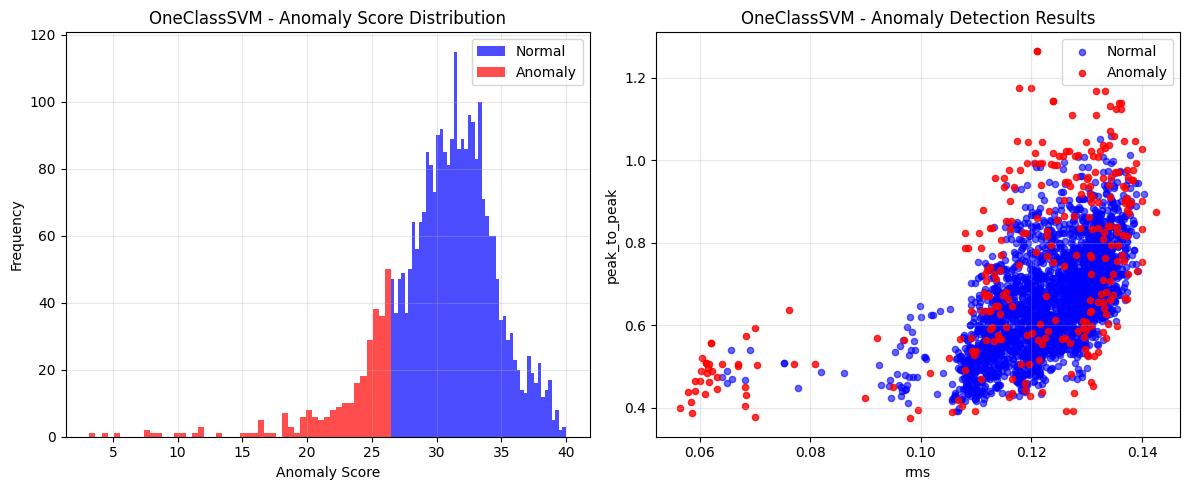

2025/08/18 15:55:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Successfully registered model 'vibration_anomaly_oneclasssvm'.
2025/08/18 15:55:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: vibration_anomaly_oneclasssvm, version 1


  - Anomaly rate: 0.101
  - Anomalies detected: 290/2880
  - Mean anomaly score: 30.8414
  - MLflow run ID: 7c6b85b9e8ac40ab90ee6558e60ee42d
🏃 View run Vibration_OneClassSVM at: http://mlflow:5000/#/experiments/4/runs/7c6b85b9e8ac40ab90ee6558e60ee42d
🧪 View experiment at: http://mlflow:5000/#/experiments/4

=== Vibration Gauntlet Results Summary ===
IsolationForest:
  - Anomaly Detection Rate: 0.100
  - Anomalies Found: 288 out of 2880 samples
  - Anomaly Score Range: -0.4508 ± 0.0489
OneClassSVM:
  - Anomaly Detection Rate: 0.101
  - Anomalies Found: 290 out of 2880 samples
  - Anomaly Score Range: 30.8414 ± 3.9504

All models have been successfully registered in MLflow Model Registry!
View results at: http://mlflow:5000


Created version '1' of model 'vibration_anomaly_oneclasssvm'.


In [4]:
# Prepare data for anomaly detection training
print("=== Anomaly Detection Model Training ===")

# Select feature columns for modeling
feature_columns = ['rms', 'peak_to_peak', 'kurtosis', 'skewness', 'std', 'crest_factor',
                   'dominant_freq', 'dominant_freq_amplitude', 'spectral_centroid', 'high_freq_energy']

X = features_df[feature_columns].copy()

# Handle any infinite or NaN values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

print(f"Training data shape: {X.shape}")
print(f"Features used: {feature_columns}")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define models to train
models = {
    'IsolationForest': IsolationForest(contamination=0.1, random_state=42, n_estimators=100),
    'OneClassSVM': OneClassSVM(nu=0.1, kernel='rbf', gamma='scale')
}

# Train models and log to MLflow
model_results = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    
    with mlflow.start_run(run_name=f"Vibration_{model_name}") as run:
        # Train model
        model.fit(X_scaled)
        
        # Generate predictions (-1 for anomaly, 1 for normal)
        predictions = model.predict(X_scaled)
        anomaly_scores = model.score_samples(X_scaled) if hasattr(model, 'score_samples') else model.decision_function(X_scaled)
        
        # Calculate metrics
        n_anomalies = np.sum(predictions == -1)
        anomaly_rate = n_anomalies / len(predictions)
        
        # Log parameters
        mlflow.log_params(model.get_params())
        
        # Log metrics
        mlflow.log_metric("anomaly_rate", anomaly_rate)
        mlflow.log_metric("n_anomalies", n_anomalies)
        mlflow.log_metric("n_normal", len(predictions) - n_anomalies)
        mlflow.log_metric("mean_anomaly_score", np.mean(anomaly_scores))
        mlflow.log_metric("std_anomaly_score", np.std(anomaly_scores))
        
        # Create anomaly score distribution plot
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.hist(anomaly_scores[predictions == 1], bins=50, alpha=0.7, label='Normal', color='blue')
        plt.hist(anomaly_scores[predictions == -1], bins=50, alpha=0.7, label='Anomaly', color='red')
        plt.xlabel('Anomaly Score')
        plt.ylabel('Frequency')
        plt.title(f'{model_name} - Anomaly Score Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Create scatter plot of first two features colored by anomaly prediction
        plt.subplot(1, 2, 2)
        normal_mask = predictions == 1
        anomaly_mask = predictions == -1
        
        plt.scatter(X.iloc[normal_mask, 0], X.iloc[normal_mask, 1], 
                   c='blue', alpha=0.6, s=20, label='Normal')
        plt.scatter(X.iloc[anomaly_mask, 0], X.iloc[anomaly_mask, 1], 
                   c='red', alpha=0.8, s=20, label='Anomaly')
        plt.xlabel(feature_columns[0])
        plt.ylabel(feature_columns[1])
        plt.title(f'{model_name} - Anomaly Detection Results')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plot_path = f'docs/ml/vibration_{model_name.lower()}_results.png'
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        # Log plot as artifact
        mlflow.log_artifact(plot_path)
        
        # Log feature importance if available
        if hasattr(model, 'feature_importances_'):
            feature_importance = pd.DataFrame({
                'feature': feature_columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            feature_importance.to_csv(f'docs/ml/{model_name.lower()}_feature_importance.csv', index=False)
            mlflow.log_artifact(f'docs/ml/{model_name.lower()}_feature_importance.csv')
        
        # Log model
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="model",
            registered_model_name=f"vibration_anomaly_{model_name.lower()}"
        )
        
        # Store results
        model_results[model_name] = {
            'model': model,
            'anomaly_rate': anomaly_rate,
            'n_anomalies': n_anomalies,
            'mean_score': np.mean(anomaly_scores),
            'std_score': np.std(anomaly_scores),
            'run_id': run.info.run_id
        }
        
        print(f"  - Anomaly rate: {anomaly_rate:.3f}")
        print(f"  - Anomalies detected: {n_anomalies}/{len(predictions)}")
        print(f"  - Mean anomaly score: {np.mean(anomaly_scores):.4f}")
        print(f"  - MLflow run ID: {run.info.run_id}")

# Summary of results
print(f"\n=== Vibration Gauntlet Results Summary ===")
for model_name, results in model_results.items():
    print(f"{model_name}:")
    print(f"  - Anomaly Detection Rate: {results['anomaly_rate']:.3f}")
    print(f"  - Anomalies Found: {results['n_anomalies']} out of {len(X)} samples")
    print(f"  - Anomaly Score Range: {results['mean_score']:.4f} ± {results['std_score']:.4f}")
    
print(f"\nAll models have been successfully registered in MLflow Model Registry!")
print(f"View results at: {mlflow.get_tracking_uri()}")

In [5]:
# Advanced Analysis and Insights
print("=== Advanced Vibration Analysis ===")

# Analyze anomaly patterns by bearing and sensor position
anomaly_df = features_df.copy()
anomaly_df['predictions_isolation'] = models['IsolationForest'].predict(X_scaled)
anomaly_df['predictions_svm'] = models['OneClassSVM'].predict(X_scaled)

# Anomaly distribution by bearing
bearing_anomaly_summary = pd.DataFrame({
    'bearing_id': anomaly_df['bearing_id'],
    'isolation_forest_anomaly': anomaly_df['predictions_isolation'] == -1,
    'oneclass_svm_anomaly': anomaly_df['predictions_svm'] == -1
}).groupby('bearing_id').agg({
    'isolation_forest_anomaly': ['count', 'sum', 'mean'],
    'oneclass_svm_anomaly': ['count', 'sum', 'mean']
}).round(3)

print("Anomaly Detection by Bearing:")
print(bearing_anomaly_summary)

# Sensor position analysis
sensor_anomaly_summary = pd.DataFrame({
    'sensor_position': anomaly_df['sensor_position'],
    'isolation_forest_anomaly': anomaly_df['predictions_isolation'] == -1,
    'oneclass_svm_anomaly': anomaly_df['predictions_svm'] == -1
}).groupby('sensor_position').agg({
    'isolation_forest_anomaly': ['count', 'sum', 'mean'],
    'oneclass_svm_anomaly': ['count', 'sum', 'mean']
}).round(3)

print("\nAnomaly Detection by Sensor Position:")
print(sensor_anomaly_summary)

# Feature importance analysis for anomalies
print("\n=== Feature Analysis for Detected Anomalies ===")

# Compare feature values between normal and anomaly samples
anomaly_mask_iso = anomaly_df['predictions_isolation'] == -1
normal_mask_iso = anomaly_df['predictions_isolation'] == 1

feature_comparison = pd.DataFrame({
    'feature': feature_columns,
    'normal_mean': X[normal_mask_iso].mean(),
    'anomaly_mean': X[anomaly_mask_iso].mean(),
    'difference': X[anomaly_mask_iso].mean() - X[normal_mask_iso].mean(),
    'ratio': X[anomaly_mask_iso].mean() / X[normal_mask_iso].mean()
}).round(4)

feature_comparison['abs_difference'] = abs(feature_comparison['difference'])
feature_comparison = feature_comparison.sort_values('abs_difference', ascending=False)

print("Feature comparison (Normal vs. Anomalous samples) - IsolationForest:")
print(feature_comparison[['feature', 'normal_mean', 'anomaly_mean', 'difference', 'ratio']])

# Key insights about vibration patterns
print(f"\n=== Key Insights from Vibration Analysis ===")
print(f"1. Dataset Coverage:")
print(f"   - Processed {len(sample_files)} files with {len(features_df)} feature windows")
print(f"   - Analyzed {features_df['bearing_id'].nunique()} bearings with {window_size} sample windows")
print(f"   - Frequency resolution: {20000/window_size:.1f} Hz per bin")

print(f"\n2. Signal Characteristics:")
most_important_features = feature_comparison.head(3)['feature'].tolist()
print(f"   - Most discriminative features: {', '.join(most_important_features)}")
print(f"   - RMS values range: {X['rms'].min():.4f} to {X['rms'].max():.4f}")
print(f"   - Dominant frequencies: {X['dominant_freq'].min():.0f} to {X['dominant_freq'].max():.0f} Hz")

print(f"\n3. Anomaly Detection Performance:")
for model_name, results in model_results.items():
    print(f"   - {model_name}: {results['anomaly_rate']:.1%} anomaly rate")

print(f"\n4. Industrial Significance:")
print(f"   - Kurtosis > 3 may indicate bearing defects (impulsive signals)")
print(f"   - High-frequency energy indicates surface roughness or defects")
print(f"   - Crest factor > 3-4 suggests intermittent impacts")

# Save comprehensive results
results_summary = {
    'experiment_name': 'Vibration Gauntlet (NASA)',
    'dataset': 'NASA IMS Bearing Dataset - 1st Test',
    'files_processed': len(sample_files),
    'total_windows': len(features_df),
    'window_size': window_size,
    'sampling_frequency': 20000,
    'features_extracted': len(feature_columns),
    'models_trained': list(model_results.keys()),
    'mlflow_uri': tracking_uri
}

# Log summary to file
import json
with open('docs/ml/vibration_gauntlet_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"\n=== Phase 2: Vibration Gauntlet COMPLETE ===")
print(f"✅ Successfully processed NASA bearing vibration data")
print(f"✅ Extracted {len(feature_columns)} signal processing features")  
print(f"✅ Trained and registered {len(models)} anomaly detection models")
print(f"✅ All models available in MLflow Model Registry")
print(f"✅ Ready for Phase 3: Audio Gauntlet!")

# Display final dataset info
print(f"\nFinal dataset shape: {features_df.shape}")
print(f"Feature columns: {feature_columns}")
print(f"MLflow tracking URI: {tracking_uri}")

=== Advanced Vibration Analysis ===
Anomaly Detection by Bearing:
           isolation_forest_anomaly             oneclass_svm_anomaly       \
                              count  sum   mean                count  sum   
bearing_id                                                                  
bearing_1                       720   47  0.065                  720   66   
bearing_2                       720   17  0.024                  720   44   
bearing_3                       720  143  0.199                  720   74   
bearing_4                       720   81  0.112                  720  106   

                   
             mean  
bearing_id         
bearing_1   0.092  
bearing_2   0.061  
bearing_3   0.103  
bearing_4   0.147  

Anomaly Detection by Sensor Position:
                isolation_forest_anomaly            oneclass_svm_anomaly       \
                                   count  sum  mean                count  sum   
sensor_position                                      